In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import smtplib
from datetime import datetime, timedelta
from dateutil.relativedelta import *
from requests_html import HTMLSession
import sys, os
import io
import quandl as quandl 
from hurst import compute_Hc
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency

In [129]:
final_df = pd.DataFrame()
start_date = '2006-01-01'
end_date = '2020-12-31'
api_string="44ErNV5zLdE6K7QpDWff"

def get_data(stock_code):
    start_time = datetime(2006, 1, 1, 0, 0) 
#     end_time = datetime.today()
    end_time = datetime(2020, 12, 31, 0, 0) 
    day_type = '1d'

    df = yf.download(stock_code,start=start_time,end=end_time,interval=day_type)            
    df = df.fillna(method='ffill')
    return df

# 1) Portfoilo DF

Purpose - To prevent return of more than -10%

Observation 
- When things go south, transfer more assets to US 5Y Treasury Futures (Low Risk, Medium Reward)- 
- Commodity Return is bad - Only have position when you are super confident (High Risk, Low Reward)
- World index - Go in if it is possible (Medium Risk, High Reward)

In [269]:
portfoilo_data = pd.read_excel('DATA INPUTS 2001 - 2021.xlsx')
portfoilo_data = portfoilo_data.set_index('Dates')
portfoilo_data = portfoilo_data.reindex(index=portfoilo_data.index[::-1])
portfoilo_data = portfoilo_data.resample('1m').mean()

portfoilo_data['MSCI World Index %'] = portfoilo_data['MSCI World Index'].pct_change()
portfoilo_data['Goldman Commodity Index %'] = portfoilo_data['Goldman Commodity Index'].pct_change()
portfoilo_data['US 5Y Treasury Futures %'] = portfoilo_data['US 5Y Treasury Futures'].pct_change()

def calculate_rsi(df):
    delta = df.diff()
    window = 15
    up_days = delta.copy()
    up_days[delta<=0]=0.0
    down_days = abs(delta.copy())
    down_days[delta>0]=0.0
    RS_up = up_days.rolling(window).mean()
    RS_down = down_days.rolling(window).mean()
    rsi= 100-100/(1+RS_up/RS_down)
    return(rsi)

portfoilo_data['MSCI World Index RSI'] = calculate_rsi(portfoilo_data['MSCI World Index'])
portfoilo_data['Goldman Commodity Index RSI'] = calculate_rsi(portfoilo_data['Goldman Commodity Index'])
portfoilo_data['US 5Y Treasury Futures RSI'] = calculate_rsi(portfoilo_data['US 5Y Treasury Futures'])

portfoilo_data['MSCI Index RSI Score'] = np.where(portfoilo_data['MSCI World Index RSI'] > 60, 1, np.where(portfoilo_data['MSCI World Index RSI'] < 40, -1, 0))
portfoilo_data['Goldman Commodity Index RSI Score'] = np.where(portfoilo_data['Goldman Commodity Index RSI'] > 60, 1, np.where(portfoilo_data['Goldman Commodity Index RSI'] < 40, -1, 0))
portfoilo_data['US 5Y Treasury Futures RSI Score'] = np.where(portfoilo_data['US 5Y Treasury Futures RSI'] > 60, 1, np.where(portfoilo_data['US 5Y Treasury Futures RSI'] < 40, -1, 0))

portfoilo_data['MSCI World Index 5MA'] = portfoilo_data['MSCI World Index'].rolling(5).mean()
portfoilo_data['Goldman Commodity Index 5MA'] = portfoilo_data['Goldman Commodity Index'].rolling(5).mean()
portfoilo_data['US 5Y Treasury Futures 5MA'] = portfoilo_data['US 5Y Treasury Futures'].rolling(5).mean()

portfoilo_data['MSCI World Index 15MA'] = portfoilo_data['MSCI World Index'].rolling(15).mean()
portfoilo_data['Goldman Commodity Index 15MA'] = portfoilo_data['Goldman Commodity Index'].rolling(15).mean()
portfoilo_data['US 5Y Treasury Futures 15MA'] = portfoilo_data['US 5Y Treasury Futures'].rolling(15).mean()

portfoilo_data['MSCI World Index Uptrending'] = np.where((portfoilo_data['MSCI World Index'] > portfoilo_data['MSCI World Index 5MA']) &
                                                         (portfoilo_data['MSCI World Index 5MA'] > portfoilo_data['MSCI World Index 15MA']), 1, 0)
portfoilo_data['Goldman Commodity Index Uptrending'] = np.where((portfoilo_data['Goldman Commodity Index'] > portfoilo_data['Goldman Commodity Index 5MA']) &
                                                                (portfoilo_data['Goldman Commodity Index 5MA'] > portfoilo_data['Goldman Commodity Index 15MA']), 1, 0)
portfoilo_data['US 5Y Treasury Futures Uptrending'] = np.where((portfoilo_data['US 5Y Treasury Futures'] > portfoilo_data['US 5Y Treasury Futures 5MA']) &
                                                                (portfoilo_data['US 5Y Treasury Futures 5MA'] > portfoilo_data['US 5Y Treasury Futures 15MA']), 1, 0)

portfoilo_data['MSCI World Index Downtrending'] = np.where((portfoilo_data['MSCI World Index'] < portfoilo_data['MSCI World Index 5MA']) &
                                                         (portfoilo_data['MSCI World Index 5MA'] < portfoilo_data['MSCI World Index 15MA']), 1, 0)
portfoilo_data['Goldman Commodity Index Downtrending'] = np.where((portfoilo_data['Goldman Commodity Index'] < portfoilo_data['Goldman Commodity Index 5MA']) &
                                                                (portfoilo_data['Goldman Commodity Index 5MA'] < portfoilo_data['Goldman Commodity Index 15MA']), 1, 0)
portfoilo_data['US 5Y Treasury Futures Downtrending'] = np.where((portfoilo_data['US 5Y Treasury Futures'] < portfoilo_data['US 5Y Treasury Futures 5MA']) &
                                                                (portfoilo_data['US 5Y Treasury Futures 5MA'] < portfoilo_data['US 5Y Treasury Futures 15MA']), 1, 0)

portfoilo_data['MSCI World Index Overall Return'] = portfoilo_data['MSCI World Index'].pct_change().cumsum()
portfoilo_data['Goldman Commodity Index Overall Return'] = portfoilo_data['Goldman Commodity Index'].pct_change().cumsum()
portfoilo_data['US 5Y Treasury Futures Overall Return'] = portfoilo_data['US 5Y Treasury Futures'].pct_change().cumsum()

portfoilo_data['MSCI World Index Monthly Return'] = portfoilo_data['MSCI World Index'].pct_change()
portfoilo_data['Goldman Commodity Index Monthly Return'] = portfoilo_data['Goldman Commodity Index'].pct_change()
portfoilo_data['US 5Y Treasury Futures Monthly Return'] = portfoilo_data['US 5Y Treasury Futures'].pct_change()

# 0 = low risk, 1 = medium risk, 2 = high risk
portfoilo_data['MSCI World Index Return Type'] = np.where(portfoilo_data['MSCI World Index Monthly Return'] >= 0.025, 0, np.where((portfoilo_data['MSCI World Index Monthly Return'] < 0.025) & (portfoilo_data['MSCI World Index Monthly Return'] > -0.025),1,2))
portfoilo_data['Goldman Commodity Index Return Type'] = np.where(portfoilo_data['Goldman Commodity Index Monthly Return'] >= 0.025, 0, np.where((portfoilo_data['Goldman Commodity Index Monthly Return'] < 0.025) & (portfoilo_data['Goldman Commodity Index Monthly Return'] > -0.025),1,2))
portfoilo_data['US 5Y Treasury Futures Return Type'] = np.where(portfoilo_data['US 5Y Treasury Futures Monthly Return'] >= 0.025, 0, np.where((portfoilo_data['US 5Y Treasury Futures Monthly Return'] < 0.025) & (portfoilo_data['US 5Y Treasury Futures Monthly Return'] > -0.025),1,2))
    
portfoilo_data = portfoilo_data[(portfoilo_data.index > '2006-01-01') &
                                (portfoilo_data.index < '2020-12-31')]

final_df['MSCI World Index %'] = portfoilo_data['MSCI World Index %']
final_df['Goldman Commodity Index %'] = portfoilo_data['Goldman Commodity Index %']
final_df['US 5Y Treasury Futures %'] = portfoilo_data['US 5Y Treasury Futures %']

final_df['MSCI World Index Return Type'] = portfoilo_data['MSCI World Index Return Type'] 
final_df['Goldman Commodity Index Return Type'] = portfoilo_data['Goldman Commodity Index Return Type'] 
final_df['US 5Y Treasury Futures Return Type'] = portfoilo_data['US 5Y Treasury Futures Return Type'] 

final_df['MSCI World Index RSI'] = portfoilo_data['MSCI World Index RSI']
final_df['Goldman Commodity Index RSI'] = portfoilo_data['Goldman Commodity Index RSI']
final_df['US 5Y Treasury Futures RSI'] = portfoilo_data['US 5Y Treasury Futures RSI']

final_df['MSCI Index RSI Score'] = portfoilo_data['MSCI Index RSI Score'] 
final_df['Goldman Commodity Index RSI Score'] = portfoilo_data['Goldman Commodity Index RSI Score'] 
final_df['US 5Y Treasury Futures RSI Score'] = portfoilo_data['US 5Y Treasury Futures RSI Score'] 

final_df['MSCI World Index Uptrending'] = portfoilo_data['MSCI World Index Uptrending']
final_df['Goldman Commodity Index Uptrending'] = portfoilo_data['Goldman Commodity Index Uptrending']
final_df['US 5Y Treasury Futures Uptrending'] = portfoilo_data['US 5Y Treasury Futures Uptrending']

final_df['MSCI World Index Downtrending'] = portfoilo_data['MSCI World Index Downtrending']
final_df['Goldman Commodity Index Downtrending'] = portfoilo_data['Goldman Commodity Index Downtrending']
final_df['US 5Y Treasury Futures Downtrending'] = portfoilo_data['US 5Y Treasury Futures Downtrending']

# display(portfoilo_data.head())

portfoilo_figure = px.line(portfoilo_data, x=portfoilo_data.index, y=['MSCI World Index','Goldman Commodity Index','US 5Y Treasury Futures'], title='Portfoilo Value')
portfoilo_figure.update_layout(hovermode="x")
portfoilo_figure.show()

portfoilo_figurea = px.line(portfoilo_data, x=portfoilo_data.index, y=['MSCI World Index', 'MSCI World Index 5MA','MSCI World Index 15MA'], title='MSCI World Index')
portfoilo_figurea.update_layout(hovermode="x")
portfoilo_figurea.show()

portfoilo_figureb = px.line(portfoilo_data, x=portfoilo_data.index, y=['Goldman Commodity Index','Goldman Commodity Index 5MA','Goldman Commodity Index 15MA'], title='Goldman Commodity Index')
portfoilo_figureb.update_layout(hovermode="x")
portfoilo_figureb.show()

portfoilo_figurec = px.line(portfoilo_data, x=portfoilo_data.index, y=['US 5Y Treasury Futures','US 5Y Treasury Futures 5MA','US 5Y Treasury Futures 15MA'], title='US 5Y Treasury Futures')
portfoilo_figurec.update_layout(hovermode="x")
portfoilo_figurec.show()

portfoilo_figure3 = px.line(portfoilo_data, x=portfoilo_data.index, y=['MSCI World Index Overall Return','Goldman Commodity Index Overall Return','US 5Y Treasury Futures Overall Return'], title='Portfoilo Overall Return')
portfoilo_figure3.update_layout(hovermode="x")
portfoilo_figure3.show()

portfoilo_figure4 = px.line(portfoilo_data, x=portfoilo_data.index, y=['MSCI World Index Monthly Return','Goldman Commodity Index Monthly Return','US 5Y Treasury Futures Monthly Return'], title='Portfoilo Monthly Return')
portfoilo_figure4.update_layout(hovermode="x")
portfoilo_figure4.show()

portfoilo_figure_rsi = px.line(portfoilo_data, x=portfoilo_data.index, y=['MSCI World Index RSI','Goldman Commodity Index RSI','US 5Y Treasury Futures RSI'], title='Portfoilo RSI')
portfoilo_figure_rsi.update_layout(hovermode="x")
portfoilo_figure_rsi.show()



# 1.1) Hurst Exponent

In [120]:
years = range(2006, 2021)
portfoilo = ['MSCI World Index','Goldman Commodity Index','US 5Y Treasury Futures']
  
portfoilo_data2 = pd.read_excel('DATA INPUTS 2001 - 2021.xlsx')
portfoilo_data2 = portfoilo_data2.set_index('Dates')
portfoilo_data2 = portfoilo_data2.reindex(index=portfoilo_data2.index[::-1])

for product in portfoilo:

    hurst_exponent_list = []
    date_list = []
    for single_year in years:
        resample_data_year = portfoilo_data2[(portfoilo_data2.index.year == single_year)]

        date_range = range(0, len(resample_data_year), 131)
        for n in date_range:
            resample_data_year_specific = resample_data_year[n:n+131]    
            H = compute_Hc(resample_data_year_specific[product], kind="price")[0]
            hurst_exponent_list.append(H)
            
            if n == 0:
                date_list.append(str(single_year) + '-' + str(1))
            else:
                date_list.append(str(single_year) + '-' + str(7))
                
#     display(date_list)
#     display(hurst_exponent_list)
    portfoilo_figure = px.line(x=date_list, y=hurst_exponent_list, title=(product + ' hurst exponent'))
    portfoilo_figure.update_layout(hovermode="x")
    portfoilo_figure.show()

# 2) Risk Indicator

## 2.1) Gold

In [265]:
gold_data = pd.read_csv('XAU_USD Historical Data.csv')
gold_data['Date'] = pd.to_datetime(gold_data['Date'])
gold_data = gold_data.set_index('Date').sort_index()
# gold_data = gold_data.reindex(index=gold_data.index[::-1])
gold_data['Price'] = pd.to_numeric(gold_data['Price'].str.replace(',',''))

gold_data = gold_data.resample('1m').mean()

gold_data['price 5MA'] = gold_data['Price'].rolling(5).mean()
gold_data['price 15MA'] = gold_data['Price'].rolling(15).mean()
gold_data['percent change'] = gold_data['Price'].pct_change()
gold_data['Overall Return'] = gold_data['percent change'].cumsum()

gold_data['Gold Uptrending'] = np.where((gold_data['Price'] > gold_data['price 5MA']) & (gold_data['price 5MA'] > gold_data['price 15MA']), 1,0)
gold_data['Gold Downtrending'] = np.where((gold_data['Price'] < gold_data['price 5MA']) & (gold_data['price 5MA'] < gold_data['price 15MA']), -1,0)

final_df['Gold percent change'] = gold_data['percent change'] 
final_df['Gold Uptrending'] = gold_data['Gold Uptrending']
final_df['Gold Downtrending'] = gold_data['Gold Downtrending']
# display(gold_data.head())

gold_figure = px.line(gold_data, x=gold_data.index, y=["Price","price 5MA","price 15MA"], title='Gold Value')
gold_figure.update_layout(hovermode="x")
gold_figure.show()

gold_figure3 = px.line(gold_data, x=gold_data.index, y="Overall Return", title='Overall Return')
gold_figure3.update_layout(hovermode="x")
gold_figure3.show()

gold_figure4 = px.line(gold_data, x=gold_data.index, y="percent change", title='Monthly Return')
gold_figure4.update_layout(hovermode="x")
gold_figure4.show()


## 2.2) VIX

In [146]:
VIX_data = get_data('^VIX')
VIX_data = VIX_data.resample('1m').mean()

# 0 = Low Risk, 1 = Medium Risk, 2 = High Risk
VIX_data['VIX Risk Level'] = np.where(VIX_data['Adj Close'] >= 30, 2, np.where((VIX_data['Adj Close'] < 30) & (VIX_data['Adj Close'] > 20),1,0))   
                                      
final_df['VIX'] = VIX_data['Adj Close']
final_df['VIX Risk Level'] = VIX_data['VIX Risk Level']

# display(VIX_data.head())
                                      
vix_figure = px.line(VIX_data, x=VIX_data.index, y="Adj Close", title='VIX Value')
vix_figure.update_layout(hovermode="x")
vix_figure.show()


[*********************100%***********************]  1 of 1 completed


## 2.3) 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity

https://ycharts.com/indicators/10_2_year_treasury_yield_spread

In [264]:
Treasury_Data = pd.read_excel("T10Y2Y.xls")
Treasury_Data = Treasury_Data.set_index('observation_date')

Treasury_Data = Treasury_Data.resample('1m').mean()
Treasury_Data['5MA'] = Treasury_Data["T10Y2Y"].rolling(5).mean()
Treasury_Data['15MA'] = Treasury_Data["T10Y2Y"].rolling(15).mean()
Treasury_Data['Treasury Uptrending'] =  np.where((Treasury_Data["T10Y2Y"] > Treasury_Data['5MA']) &
                                                 Treasury_Data['5MA'] > Treasury_Data['15MA'], 1, 0)
Treasury_Data['Treasury Downtrending'] =  np.where((Treasury_Data["T10Y2Y"] < Treasury_Data['5MA']) &
                                                 Treasury_Data['5MA'] < Treasury_Data['15MA'], -1, 0)

Treasury_Data = Treasury_Data[(Treasury_Data.index > '2006-01-01') &
                              (Treasury_Data.index < '2020-12-31')]

# display(Treasury_Data)

treasury_figure = px.line(Treasury_Data, x=Treasury_Data.index, y=["T10Y2Y",'5MA','15MA'], title='Treasury Value')
treasury_figure.update_layout(hovermode="x")
treasury_figure.show()

final_df['T10Y2Y'] = Treasury_Data['T10Y2Y']
final_df['Treasury Uptrending'] = Treasury_Data['Treasury Uptrending']
final_df['Treasury Downtrending'] = Treasury_Data['Treasury Downtrending']

## 2.4)  United States Misery Index

In [80]:
misery_data = quandl.get("USMISERY/INDEX", api_key=api_string, start_date=start_date, end_date=end_date)

In [144]:
misery_data.index = pd.to_datetime(misery_data.index)

# Above 10 = High miserable 2
# 8 - 10 = Medium misery 1
# Below 8 = Low misery 0 
misery_data['Misery Level'] = np.where(misery_data['Misery Index'] >= 8, 2, np.where((misery_data['Misery Index'] < 8) & (misery_data['Misery Index'] >= 6), 1,0))

# display(misery_data.head())

final_df['Misery Index'] = misery_data['Misery Index']
final_df['Misery Level'] = misery_data['Misery Level']

misery_figure = px.line(misery_data, x=misery_data.index, y="Misery Index", title='Misery Value')
misery_figure.update_layout(hovermode="x")
misery_figure.show()

## 2.5) US High Yield Corporate Bond Index OAS

In [99]:
corporate_data_source = quandl.get("ML/HYOAS", api_key = api_string, start_date=start_date, end_date=end_date)

In [263]:
# The risk-free rate we will use is the one-year Treasury bill rate
# Source: https://fred.stlouisfed.org/series/DGS1
rf = pd.read_excel('DGS1.xls')
rf = rf.set_index('observation_date')
rf = rf[(rf.index > '2006-01-01') & (rf.index < '2020-12-31')]

corporate_data = corporate_data_source.copy()
corporate_data['rf'] = rf
corporate_data['corporate - rf'] = corporate_data['BAMLH0A0HYM2'] - corporate_data['rf']

corporate_data = corporate_data.resample('1m').mean()
corporate_data['5MA'] = corporate_data['corporate - rf'].rolling(5).mean()
corporate_data['15MA'] = corporate_data['corporate - rf'].rolling(15).mean()
corporate_data['Uptrending'] = np.where((corporate_data['5MA'] > corporate_data['15MA']) &
                                        (corporate_data['corporate - rf'] > corporate_data['5MA']), 1,0)
corporate_data['Downtrending'] = np.where((corporate_data['5MA'] < corporate_data['15MA']) &
                                        (corporate_data['corporate - rf'] <corporate_data['5MA']), -1,0)

final_df['corporate - rf'] = corporate_data['corporate - rf']
final_df['Corporate Uptrending'] = corporate_data['Uptrending']
final_df['Corporate Downtrending'] = corporate_data['Downtrending']

corporate_figure = px.line(corporate_data, x=corporate_data.index, y=["corporate - rf","5MA","15MA"], title='Corporate minus RF Value')
corporate_figure.update_layout(hovermode="x")
corporate_figure.show()

# 3) Combination Data 2006-2020 Overview

In [228]:
fig1 = px.imshow(final_df.corr(), 
                 labels=dict(color="Correlation"), 
                 width=1000, height=800,
                 color_continuous_scale=px.colors.sequential.matter)
fig1.show()

In [260]:
final_df

MSCI World Index %  Goldman Commodity Index %  \
Dates                                                       
2006-01-31            0.029367                   0.014476   
2006-02-28            0.002684                  -0.043333   
2006-03-31            0.017065                   0.012802   
2006-04-30            0.023141                   0.098744   
2006-05-31            0.000641                   0.017289   
...                        ...                        ...   
2020-07-31            0.031888                   0.053329   
2020-08-31            0.049191                   0.046118   
2020-09-30           -0.005399                  -0.015818   
2020-10-31            0.010459                   0.019378   
2020-11-30            0.047305                   0.040860   

            US 5Y Treasury Futures %  MSCI World Index Return Type  \
Dates                                                                
2006-01-31                  0.003113                             0   
2006-02-28                 -0.013451                             1   
2006-03-31                 -0.004944                             1   
2006-04-30                 -0.008603                             1   
2006-05-31                 -0.003515                             1   
...                              ...                           ...   
2020-07-31                  0.002926                             0   
2020-08-31                  0.000646                             0   
2020-09-30                  0.000115                             1   
2020-10-31                 -0.002080                             1   
2020-11-30                 -0.001668                             0   

            Goldman Commodity Index Return Type  \
Dates                                             
2006-01-31                                    1   
2006-02-28                                    2   
2006-03-31                                    1   
2006-04-30                                    0   
2006-05-31                                    1   
...                                         ...   
2020-07-31                                    0   
2020-08-31                                    0   
2020-09-30                                    1   
2020-10-31                                    1   
2020-11-30                                    0   

            US 5Y Treasury Futures Return Type  MSCI World Index RSI  \
Dates                                                                  
2006-01-31                                   1             81.599100   
2006-02-28                                   1             78.666557   
2006-03-31                                   1             77.865258   
2006-04-30                                   1             81.851427   
2006-05-31                                   1             80.633200   
...                                        ...                   ...   
2020-07-31                                   1             54.548207   
2020-08-31                                   1             59.832866   
2020-09-30                                   1             58.546802   
2020-10-31                                   1             57.317190   
2020-11-30                                   1             64.215728   

            Goldman Commodity Index RSI  US 5Y Treasury Futures RSI  \
Dates                                                                 
2006-01-31                    64.590228                   35.186128   
2006-02-28                    63.716138                   33.542282   
2006-03-31                    70.789903                   32.331163   
2006-04-30                    73.861246                   31.373372   
2006-05-31                    73.859144                   30.887556   
...                                 ...                         ...   
2020-07-31                    34.376919                   87.578320   
2020-08-31                    38.663590                   86.991965

# 4) Correlation Over The Years

MSCI World Index % & Gold percent change
Pearsonr Correlation


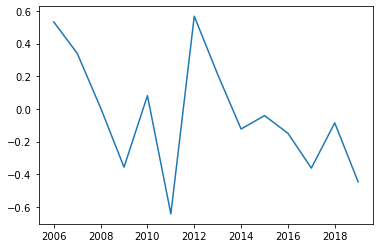

Spearman Correlation


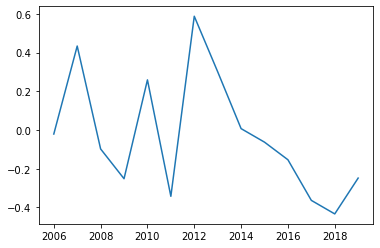

MSCI World Index % & VIX
Pearsonr Correlation


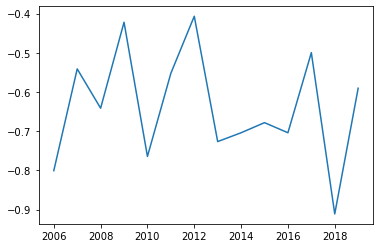

Spearman Correlation


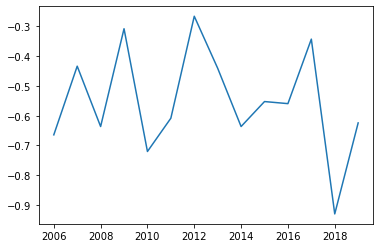

MSCI World Index % & Misery Index
Pearsonr Correlation


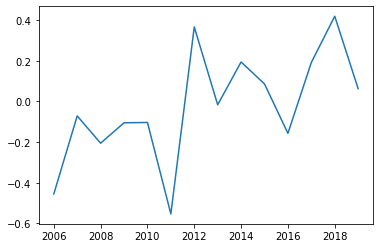

Spearman Correlation


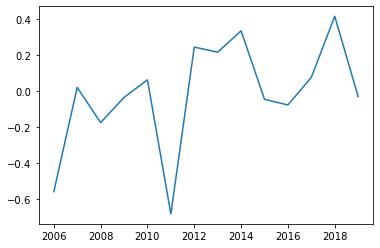

MSCI World Index % & T10Y2Y
Pearsonr Correlation


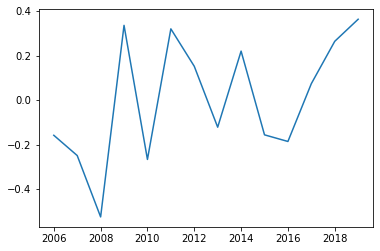

Spearman Correlation


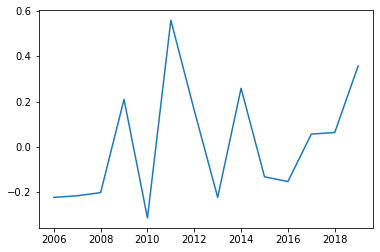

MSCI World Index % & corporate - rf
Pearsonr Correlation


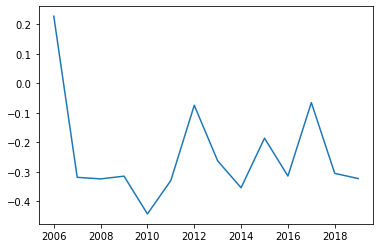

Spearman Correlation


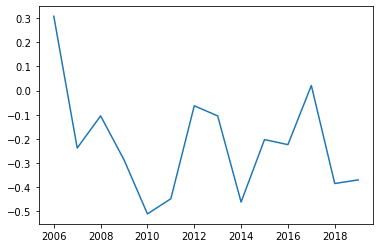

Goldman Commodity Index % & Gold percent change
Pearsonr Correlation


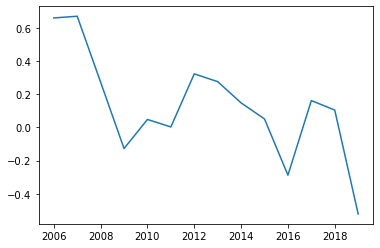

Spearman Correlation


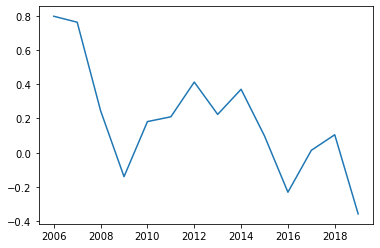

Goldman Commodity Index % & VIX
Pearsonr Correlation


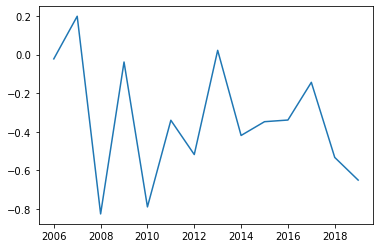

Spearman Correlation


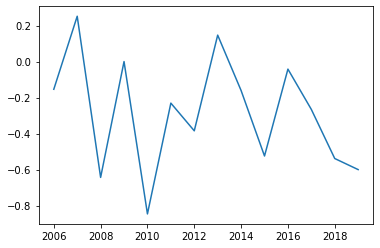

Goldman Commodity Index % & Misery Index
Pearsonr Correlation


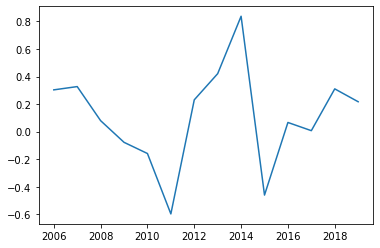

Spearman Correlation


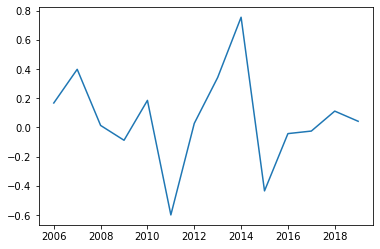

Goldman Commodity Index % & T10Y2Y
Pearsonr Correlation


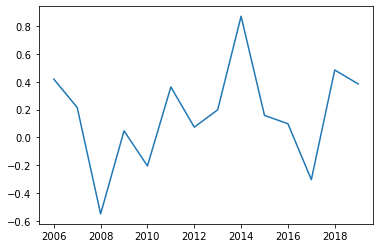

Spearman Correlation


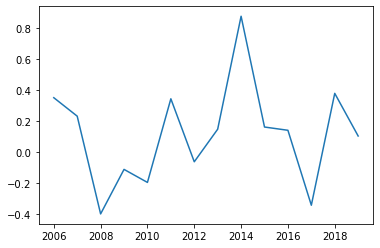

Goldman Commodity Index % & corporate - rf
Pearsonr Correlation


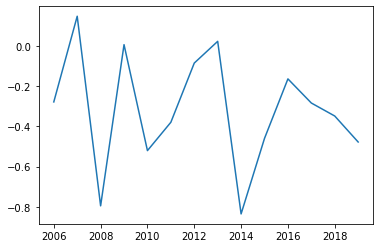

Spearman Correlation


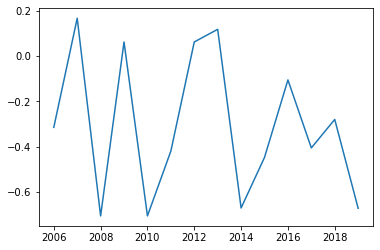

US 5Y Treasury Futures % & Gold percent change
Pearsonr Correlation


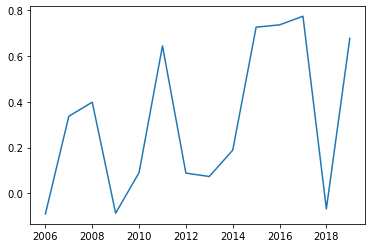

Spearman Correlation


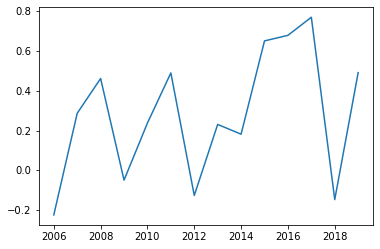

US 5Y Treasury Futures % & VIX
Pearsonr Correlation


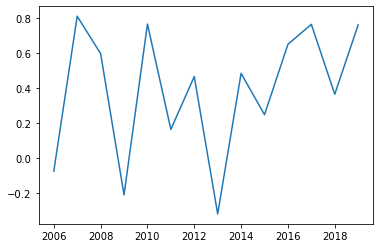

Spearman Correlation


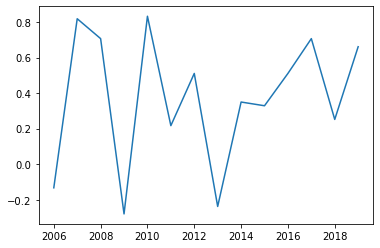

US 5Y Treasury Futures % & Misery Index
Pearsonr Correlation


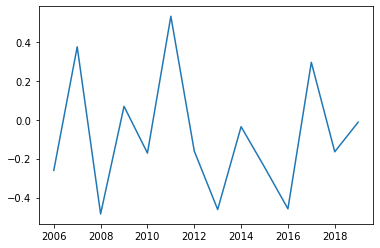

Spearman Correlation


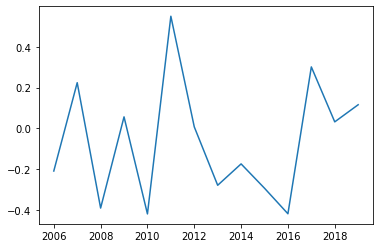

US 5Y Treasury Futures % & T10Y2Y
Pearsonr Correlation


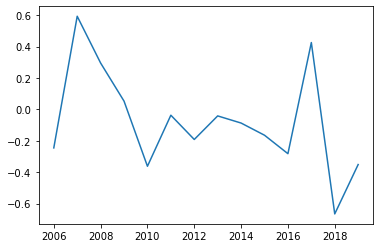

Spearman Correlation


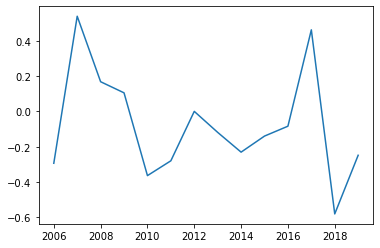

US 5Y Treasury Futures % & corporate - rf
Pearsonr Correlation


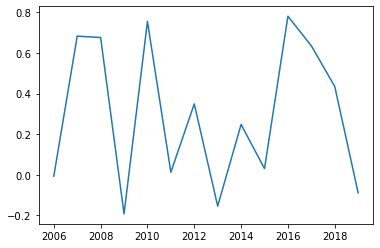

Spearman Correlation


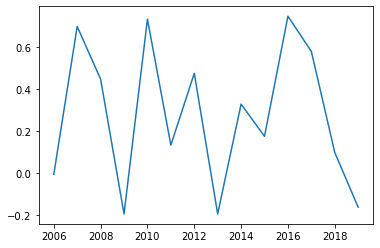

In [167]:
years = range(2006, 2020)
portfoilo = ['MSCI World Index Return Type','Goldman Commodity Index Return Type','US 5Y Treasury Futures Return Type']
risk_indicator= ['Gold percent change', 'VIX', 'Misery Index','T10Y2Y', 'corporate - rf']
           
final
for product in portfoilo:
    for risk in risk_indicator: 
        spearman_correlation_list = []
        pearsonr_correlation_list = []
        
        for single_year in years:
            resample_data_year = final_df[final_df.index.year == single_year].dropna().copy()
            resample_data_year.replace([np.inf, -np.inf], np.nan, inplace=True)
            resample_data_year = resample_data_year.dropna()
            
#             #Pearsonr - Check for linear relationship, same direction at constant rate
            pearsonr_data , _ = pearsonr(resample_data_year[product], resample_data_year[risk])
            pearsonr_correlation_list.append(pearsonr_data)
            
            #Spearman - Check for monotonic relationship, same direction different rate
            spearman_data , _ = spearmanr(resample_data_year[product], resample_data_year[risk])
            spearman_correlation_list.append(spearman_data)
                             
            #Chi-Square
#             table = [resample_data_year[product].values ** 2,
#                      resample_data_year[risk].values ** 2]
#             stat, p, dof, expected = chi2_contingency(table)
# #             print('dof=%d' % dof)
# #             print(expected)
#             # interpret test-statistic
#             prob = 0.95
#             critical = chi2.ppf(prob, dof)
#             print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
#             if abs(stat) >= critical:
#                 print('Dependent (reject H0)')
#             else:
#                 print('Independent (fail to reject H0)')
                
#         print(spearman_correlation_list)
#         print(pearsonr_correlation_list)
        
        print(product + ' & ' + risk)
        print('Pearsonr Correlation')
        plt.figure(0)
        plt.plot(years,pearsonr_correlation_list)
        plt.show()
        
        print('Spearman Correlation')
        plt.figure(1)
        plt.plot(years,spearman_correlation_list)
        plt.show()
        


# IGNORE THIS PART
# Machine Learning

In [169]:
#libraries for preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
le = preprocessing.LabelEncoder()

#libraries for evaluation
from sklearn.metrics import mean_squared_log_error,r2_score,mean_squared_error
from sklearn.model_selection import train_test_split

#libraries for models
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV,RidgeCV
from yellowbrick.regressor import AlphaSelection

from sklearn.linear_model import Lasso

from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.ensemble import AdaBoostRegressor

import xgboost as xgb

In [231]:
ml_data = final_df
ml_data.replace([np.inf, -np.inf], np.nan, inplace=True)
ml_data = ml_data.dropna()

portfoilo = ['MSCI World Index Return Type','Goldman Commodity Index Return Type','US 5Y Treasury Futures Return Type']
portfoilo_indictor1 = ['MSCI World Index RSI', 'MSCI World Index Uptrending', 'MSCI World Index Downtrending']
portfoilo_indictor2 = ['Goldman Commodity Index RSI', 'Goldman Commodity Index Uptrending', 'Goldman Commodity Index Downtrending']
portfoilo_indictor3 = ['US 5Y Treasury Futures RSI', 'US 5Y Treasury Futures Uptrending', 'US 5Y Treasury Futures Downtrending']

risk_indicator= ['Gold percent change', 'Gold Uptrending', 'Gold Downtrending',
                 'VIX', 'VIX Risk Level', 'Misery Index', 'Misery Level',
                 'T10Y2Y','Treasury Uptrending', 'Treasury Downtrending',
                 'corporate - rf', 'Corporate Uptrending', 'Corporate Downtrending']
             
feature_list_numerical =  ml_data[risk_indicator + portfoilo_indictor1]
feature_list_target = ml_data[portfoilo[0]]

df = pd.concat([feature_list_numerical, feature_list_target], axis=1)

def trainingData(df,n):
    X = df.iloc[:,n]
    y = df.iloc[:,-1:].values.T
    y=y[0]
    X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,test_size=0.2,random_state=0)
    return (X_train,X_test,y_train,y_test)

X_train,X_test,y_train,y_test=trainingData(df,list(range(len(list(df.columns))-1)))

def result(y_test,y_pred):
    r=[]
    r.append(mean_squared_log_error(y_test, y_pred))
    r.append(np.sqrt(r[0]))
    r.append(r2_score(y_test,y_pred))
    r.append(round(r2_score(y_test,y_pred)*100,4))
    return (r)

#dataframe that store the performance of each model
accu=pd.DataFrame(index=['MSLE', 'Root MSLE', 'R2 Score','Accuracy(%)'])

## 5.1) Linear Regression

In [232]:
#fitting model
LR=LinearRegression()
LR.fit(X_train,y_train)
y_pred=LR.predict(X_test)

#calculating error/accuracy
y_test_1,y_pred_1=y_test,y_pred
r1_lr=result(y_test_1,y_pred_1)
print('Coefficients: \n', LR.coef_)
print("MSLE : {}".format(r1_lr[0]))
print("Root MSLE : {}".format(r1_lr[1]))
print("R2 Score : {} or {}%".format(r1_lr[2],r1_lr[3]))
accu['Linear Regression']=r1_lr

Coefficients: 
 [-0.39157692 -0.05836997  0.15339971  0.05816688  0.14144389 -0.04775962
 -0.05613512  0.28125846 -0.41135244  0.20159454 -0.18163139 -0.05827347
  0.16358327  0.00212652 -0.23822435  0.39626065]
MSLE : 0.13805215209679492
Root MSLE : 0.37155370015220535
R2 Score : 0.09687638250409936 or 9.6876%


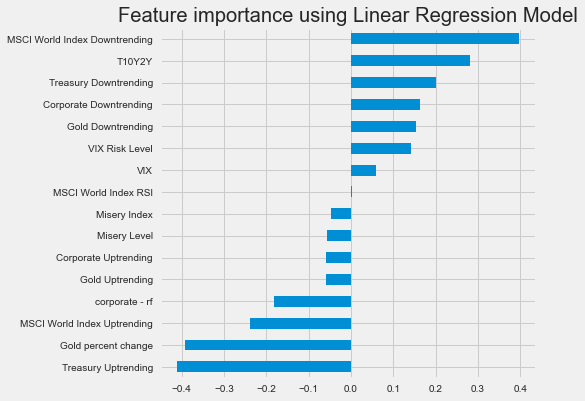

In [233]:
#Ploting feature importance graph
coef = pd.Series(LR.coef_, index = X_train.columns)
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Linear Regression Model")
plt.savefig('Linear-Regression-Feature-Importance.jpg')
plt.show()

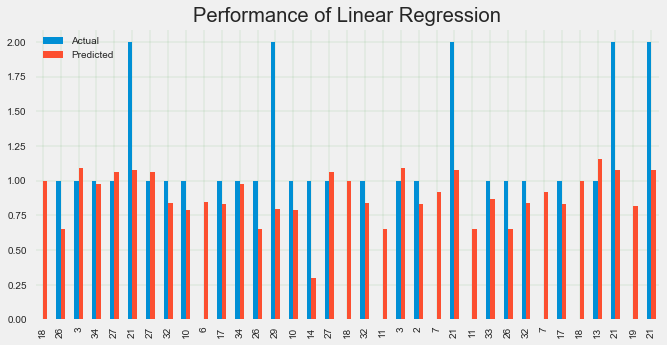

In [234]:
#Visualization of true value and predicted

df_check = pd.DataFrame({'Actual': y_test_1, 'Predicted': y_pred_1})
df_check = df_check.sample(frac=1, replace=True)
df_check.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.1', color='Green')
plt.title('Performance of Linear Regression')
plt.savefig('Linear-Regression-Performance')
plt.show()

## 5.2) Ridge regression

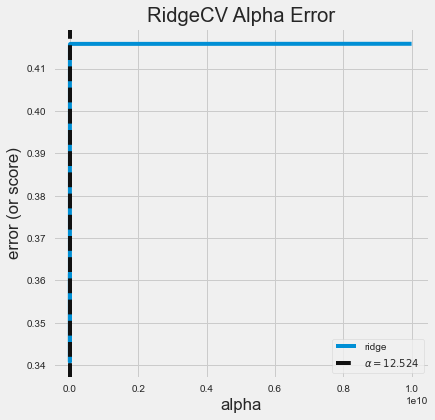

<AxesSubplot:title={'center':'RidgeCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [235]:
#predicting value of alpha

alphas = 10**np.linspace(10,-2,400)
model = RidgeCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(X_train,y_train)
visualizer.show()

In [236]:
#model object and fitting model
RR=Ridge(alpha=20.336,solver='auto')
RR.fit(X_train,y_train)
y_pred=RR.predict(X_test)

#model evaluation

y_test_2,y_pred_2=y_test,y_pred
r2_ridge=result(y_test_2,y_pred_2)
print("MSLE : {}".format(r2_ridge[0]))
print("Root MSLE : {}".format(r2_ridge[1]))
print("R2 Score : {} or {}%".format(r2_ridge[2],r2_ridge[3]))
accu['Ridge Regression']=r2_ridge

MSLE : 0.13077185990093543
Root MSLE : 0.36162392053200165
R2 Score : 0.14736285952491557 or 14.7363%


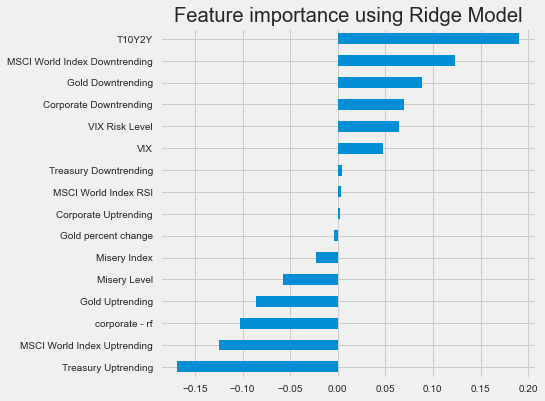

In [237]:
#Visualization of Feature Importance

coef = pd.Series(RR.coef_, index = X_train.columns)
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Ridge Model")
plt.savefig('Ridge-Regression-Feature-Importance.jpg')
plt.show()

## 5.3) Lasso Regression

In [238]:
#model object and fitting it
lasso=Lasso(alpha=0.0001)
lasso.fit(X_train,y_train)
y_pred=lasso.predict(X_test)

In [239]:
#model evaluation
y_test_3,y_pred_3=y_test,y_pred
r3_lasso=result(y_test_3,y_pred_3)
print("MSLE : {}".format(r3_lasso[0]))
print("Root MSLE : {}".format(r3_lasso[1]))
print("R2 Score : {} or {}%".format(r3_lasso[2],r3_lasso[3]))
accu['Lasso Regression']=r3_lasso

MSLE : 0.13804887922095255
Root MSLE : 0.3715492958154443
R2 Score : 0.09740105430392787 or 9.7401%


## 5.4) KNN

In [240]:
#estimating MSLE for k=1-9
R_MSLE=[]
for i in range(1,10):
    KNN=KNeighborsRegressor(n_neighbors=i)
    KNN.fit(X_train,y_train)
    y_pred=KNN.predict(X_test)
    error=np.sqrt(mean_squared_log_error(y_test, y_pred))
    R_MSLE.append(error)
    print("K =",i," , Root MSLE =",error)

K = 1  , Root MSLE = 0.4862347437552309
K = 2  , Root MSLE = 0.40456231620001354
K = 3  , Root MSLE = 0.38286100108107274
K = 4  , Root MSLE = 0.39259008293551745
K = 5  , Root MSLE = 0.38489882150465116
K = 6  , Root MSLE = 0.3841064309345964
K = 7  , Root MSLE = 0.37504644819801064
K = 8  , Root MSLE = 0.37061707907587804
K = 9  , Root MSLE = 0.3802135444129629


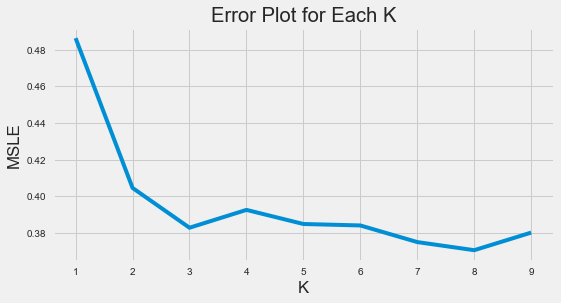

In [241]:
#plotting error
curve = pd.DataFrame(R_MSLE) #elbow curve 
plt.figure(figsize=(8,4))
plt.xticks(list(range(1,10)), list(range(1,10)), rotation='horizontal')
plt.plot(list(range(1,10)),R_MSLE)
plt.xlabel('K')
plt.ylabel('MSLE')
plt.title('Error Plot for Each K')
plt.savefig('KNN-Error-Plot.jpg')
plt.show()

In [242]:
#model implementation
KNN=KNeighborsRegressor(n_neighbors=2) 
KNN.fit(X_train,y_train)
y_pred=KNN.predict(X_test)

#model evaluation
r4_knn=result(y_test,y_pred)
print("MSLE : {}".format(r4_knn[0]))
print("Root MSLE : {}".format(r4_knn[1]))
print("R2 Score : {} or {}%".format(r4_knn[2],r4_knn[3]))
accu['KNN']=r4_knn

accu.to_csv('errors.csv')

MSLE : 0.16367066768911973
Root MSLE : 0.40456231620001354
R2 Score : -0.11918604651162767 or -11.9186%


## 5.5) Random Forest

In [243]:
RFR = RandomForestRegressor(n_estimators=180,random_state=0, min_samples_leaf=1, max_features=0.5, n_jobs=-1, oob_score=True)
RFR.fit(X_train,y_train)
y_pred = RFR.predict(X_test)

In [244]:
r5_rf=result(y_test,y_pred)
print("MSLE : {}".format(r5_rf[0]))
print("Root MSLE : {}".format(r5_rf[1]))
print("R2 Score : {} or {}%".format(r5_rf[2],r5_rf[3]))
accu['RandomForest Regressor']=r5_rf

MSLE : 0.148465239381148
Root MSLE : 0.3853118728785138
R2 Score : -0.07696430280409583 or -7.6964%


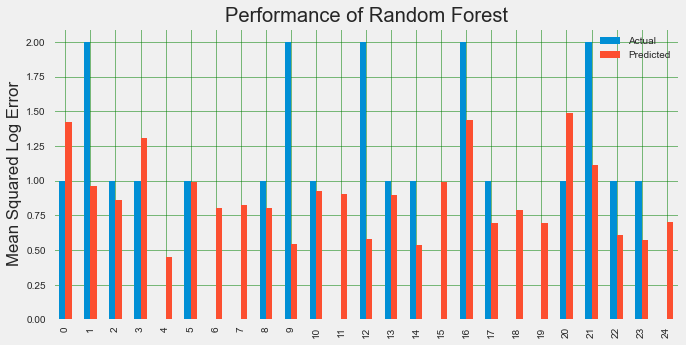

In [245]:
df_check = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_check = df_check.head(25)
#round(df_check,2)
df_check.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.title('Performance of Random Forest')
plt.ylabel('Mean Squared Log Error')
plt.savefig('Random-Forest-Performance.jpg')
plt.show()

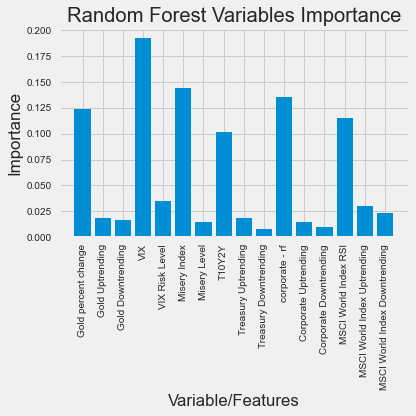

In [246]:
importances=RFR.feature_importances_
features=X_train.columns

# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.figure(figsize=(6,6))
plt.bar(x_values, importances, orientation = ('vertical'))
# Tick labels for x axis
plt.xticks(x_values, features, rotation=(90))
# Axis labels and title
plt.ylabel('Importance'); 
plt.xlabel('Variable/Features'); 
plt.title('Random Forest Variables Importance')
plt.tight_layout()
plt.savefig('Random-Forest-Variables-Importances.jpg',dpi=600)
plt.show();

## 5.6) Bagging Regressor

In [247]:
#model implementation
baggReg=BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=20),n_estimators=50, random_state=1,
                         max_samples=1.0, max_features=1.0, bootstrap=False, 
                         bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=-1, verbose=0)
baggReg.fit(X_train,y_train)
y_pred=baggReg.predict(X_test)

In [248]:
#model evaluation
r6_br=result(y_test,y_pred)
print("MSLE : {}".format(r6_br[0]))
print("Root MSLE : {}".format(r6_br[1]))
print("R2 Score : {} or {}%".format(r6_br[2],r6_br[3]))

MSLE : 0.17302438312141122
Root MSLE : 0.4159619972081719
R2 Score : -0.17830620155038712 or -17.8306%


In [249]:
accu['Bagging Regressor']=r6_br
accu.to_csv('errors.csv')

## 5.7) Adaboost

In [250]:
#model implementation
ABR = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=24),
    n_estimators=200,learning_rate=0.6
)

ABR.fit(X_train, y_train)
y_pred = ABR.predict(X_test)

#model evaluation
r7_ab=result(y_test,y_pred)
print("MSLE : {}".format(r7_ab[0]))
print("Root MSLE : {}".format(r7_ab[1]))
print("R2 Score : {} or {}%".format(r7_ab[2],r7_ab[3]))

MSLE : 0.21836416546185589
Root MSLE : 0.4672945168326458
R2 Score : -0.49224806201550364 or -49.2248%


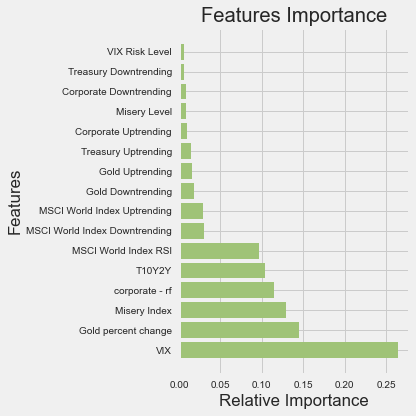

In [251]:
importances=ABR.feature_importances_
features=X_train.columns

indices = np.argsort(importances)
indices = [x for x in reversed(indices)]
plt.figure(1)
plt.title('Features Importance')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('Adaboost-Features-Importance2.jpg',dpi=60)
plt.show();

In [252]:
accu['AdaBoost Regressor']=r7_ab
accu.to_csv('errors.csv')

## 5.8) XGboost

In [253]:
# model implementation and fitting data
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.4,
                max_depth = 24, alpha = 5, n_estimators = 200)
xg_reg.fit(X_train,y_train)
y_pred = xg_reg.predict(X_test)

y_test_1,y_pred_1=y_test,y_pred
r8_xg=result(y_test_1,y_pred_1)
print("MSLE : {}".format(r8_xg[0]))
print("Root MSLE : {}".format(r8_xg[1]))
print("R2 Score : {} or {}%".format(r8_xg[2],r8_xg[3]))

MSLE : 0.1571746488426765
Root MSLE : 0.39645258082484025
R2 Score : -0.1945607682851367 or -19.4561%


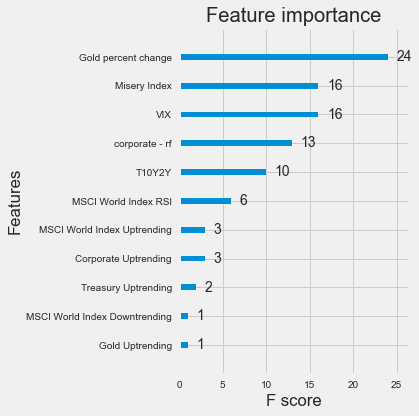

In [254]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.tight_layout()
plt.savefig('XGBoost-Features-Importance.jpg')
plt.show();

# 6) Result

In [255]:
accu=pd.read_csv('./errors.csv',index_col=0)
accu

Linear Regression  Ridge Regression  Lasso Regression        KNN  \
MSLE                  0.138052          0.130772          0.138049   0.163671   
Root MSLE             0.371554          0.361624          0.371549   0.404562   
R2 Score              0.096876          0.147363          0.097401  -0.119186   
Accuracy(%)           9.687600         14.736300          9.740100 -11.918600   

             RandomForest Regressor  Bagging Regressor  AdaBoost Regressor  
MSLE                       0.148465           0.173024            0.218364  
Root MSLE                  0.385312           0.415962            0.467295  
R2 Score                  -0.076964          -0.178306           -0.492248  
Accuracy(%)               -7.696400         -17.830600          -49.224800

In [191]:
model_accuracy=accu.loc['Accuracy(%)']

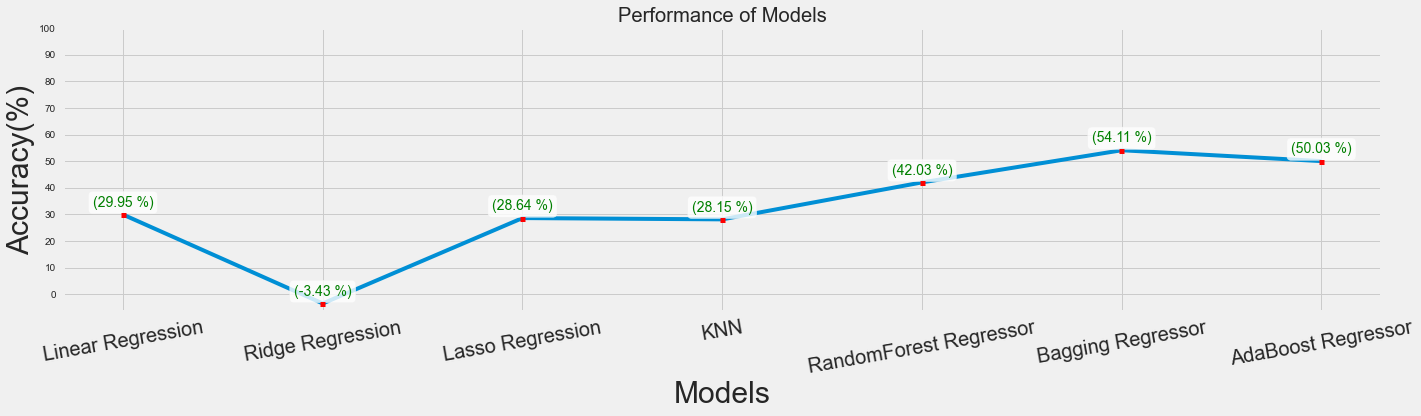

In [192]:
x=list(range(len(model_accuracy)))
y=list(range(0,101,10))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.figure(figsize=(20,6))
plt.plot(model_accuracy)
plt.yticks(y)
plt.xticks(fontsize=20)
plt.xticks(rotation = (10))
plt.xlabel("Models",fontsize=30)
plt.ylabel("Accuracy(%)",fontsize=30)
plt.title("Performance of Models")
for a,b in zip(x,y):
    b=model_accuracy[a]
    val="("+str(round(model_accuracy[a],2))+" %)"
    plt.text(a, b+4.5, val,horizontalalignment='center',verticalalignment='center',color='green',bbox=props)
    plt.text(a, b+3.5, '.',horizontalalignment='center',verticalalignment='center',color='red',fontsize=50)
plt.tight_layout()
plt.savefig('Overall-Performance.jpg',dpi=600)
plt.show();